#### Hypotesis:

If EGTM data was smoothened using exponential rolling average (most likely), \
than we could try to "unsmooth" it back to original values

In [30]:
import pandas as pd

In [31]:
# Get exponential rolling average with smothing factor alpha
def smooth(x: pd.Series, alpha=0.5):
  return pd.Series(x).ewm(alpha=alpha, adjust=False).mean().to_list()

# Undo exponential rolling average to get original values
def unsmooth(smoothed: pd.Series, alpha=0.5):
  a_prev = None
  x = []
  for ai in list(smoothed):
    if a_prev is None:
      xi = ai
    else:
      xi = a_prev + (1 / alpha) * (ai - a_prev)
    x.append(xi)
    a_prev = ai

  return x

assert [1,2,3,4] == unsmooth(smooth([1,2,3,4]))

In [44]:
data = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']) \
  .drop(columns=['file_path', 'reason']) \
  .sort_values('reportts') \
  .dropna(subset=['egtm'])

In [45]:
data.shape

(2101, 206)

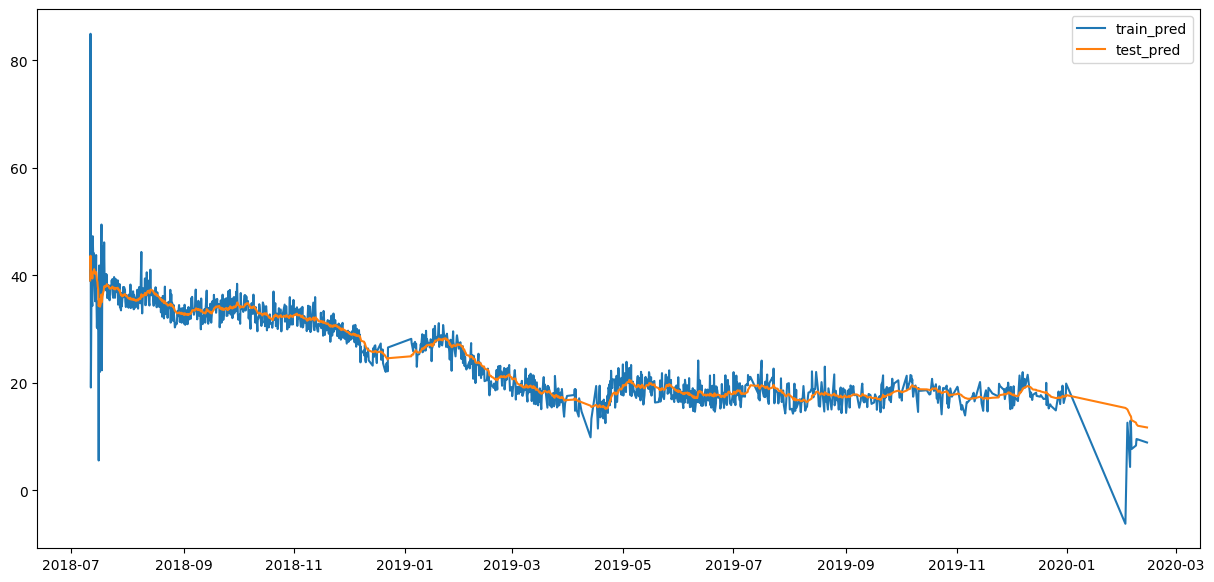

In [33]:
import matplotlib.pyplot as plt

sub = data[(data['acnum'] == 'VQ-BDU') & (data['pos'] == 2)]
plt.figure(figsize=(15, 7))
plt.plot(sub['reportts'], unsmooth(sub['egtm'], alpha=1/10), '-')
plt.plot(sub['reportts'], sub['egtm'], '-')

plt.legend(['train_pred', 'test_pred', 'true'])
plt.show()

In [34]:
selected_params = ['wai', 'nai', 'prv', 'hpv', 'xf', 'alt', 'mn', 'tat', 'n1a', 'n2a', 'ff', 'egt', 'nf']

In [35]:
fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts'])

data = pd.concat([bgu, bdu]) \
  .drop(columns=['file_path', 'reason']) \
  .sort_values('reportts')

data = data[data['acnum'].isin(fleet)].dropna(subset=['egtm'])

#### Unsmooth egtm column with 0 starting position and naive alpha=1/10

In [36]:
for ac in fleet:
  for pos in [1, 2]:
    index = (data['acnum'] == ac) & (data['pos'] == pos)
    data.loc[index, 'egtm_2'] = data.loc[index, 'egtm']
    data.loc[index, 'egtm_unsmooth'] = unsmooth(data.loc[index, 'egtm'], alpha=1/10)

In [37]:
data[['egtm', 'egtm_2']]

,egtm,egtm_2
781,39.054,39.054
782,43.644,43.644
783,41.193,41.193
784,40.531,40.531
785,39.994,39.994
...,...,...
1668,16.755,16.755
834,17.039,17.039
1669,16.916,16.916
780,15.976,15.976


#### Train baseline on unsmoothed data

In [38]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_model(X, y, model = 'linreg'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  model = Ridge(alpha=0.2)

  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  mse = mean_squared_error(y_train, predicted_train, squared=False)
  mae = mean_absolute_error(y_train, predicted_train)

  predicted_test = model.predict(X_test)
  mse = mean_squared_error(y_test, predicted_test, squared=False)
  mae = mean_absolute_error(y_test, predicted_test)
  r2 = r2_score(y_test, predicted_test)

  return mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test

In [39]:
import matplotlib.pyplot as plt

def plot_predictions(data, acnum, pos, train_i, predicted_test, predicted_train, is_smooth=True, figsize=(14, 7), title=None):
  data.loc[:train_i-1, 'pred_train'] = predicted_train
  data.loc[train_i:, 'pred_test'] = predicted_test

  sub = data[(data['acnum'] == acnum) & (data['pos'] == pos)]
  train_i2 = sub['pred_train'].count()

  plt.figure(figsize=figsize)

  if is_smooth:
    plt.plot(sub['reportts'][:train_i2], smooth(sub['pred_train'][:train_i2], alpha=0.3), '-')
    plt.plot(sub['reportts'], smooth(sub['pred_test'], alpha=0.3), '-')
  else:
    plt.scatter(sub['reportts'][:train_i2], sub['pred_train'][:train_i2], s=2)
    plt.scatter(sub['reportts'], sub['pred_test'], s=2)

  plt.plot(sub['reportts'], sub['egtm'], '-', color='#2ca02c')

  plt.title(f'Linear model of EGTM on {acnum} engine {pos}, Gas path params' if title is None else title)
  plt.legend(['train_pred', 'test_pred', 'true'])
  plt.show()


In [40]:
X = data[selected_params]
y = data['egtm_unsmooth']

mse, mae, r2, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)
print(mse, mae, r2)

avg_test = ([None] * train_i) + smooth(predicted_test, alpha=1/20)
avg_train = smooth(predicted_train, alpha=1/20) + ([None] * (len(data) - train_i)) 

data['train_pred'] = avg_train
data['test_pred'] = avg_test


4.034359283797618 2.996474106972922 -0.16982513080181127


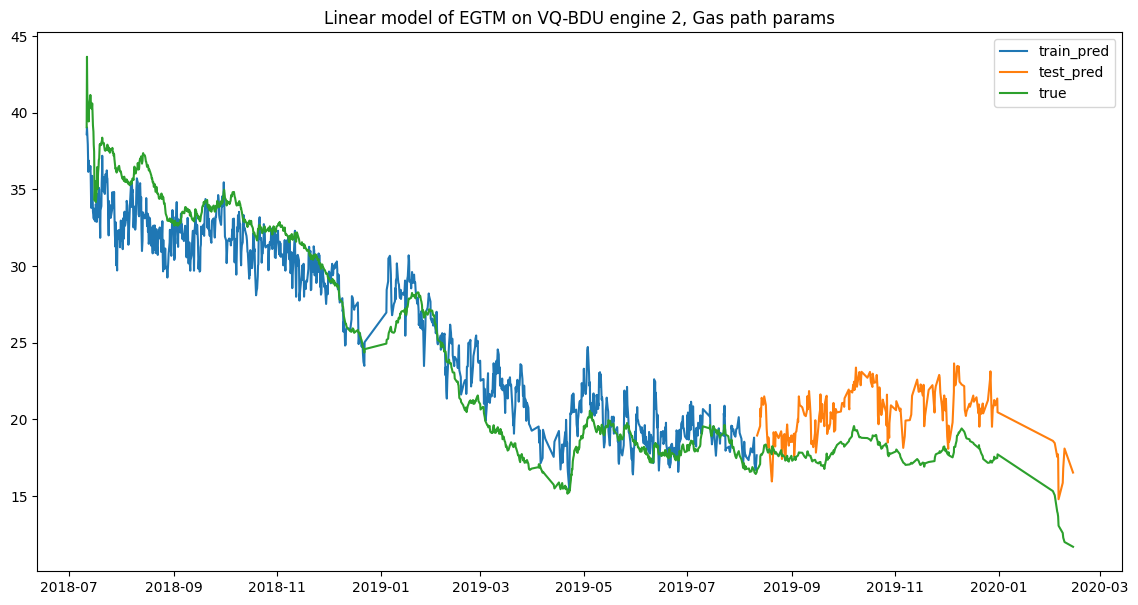

In [43]:
plot_predictions(data.reset_index(), 'VQ-BDU', 2, train_i, predicted_test, predicted_train, is_smooth=True)

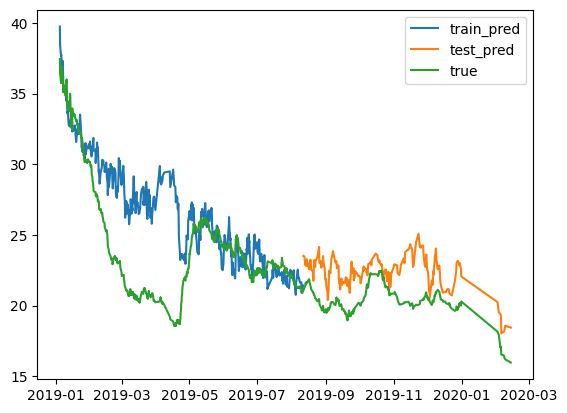

In [42]:
import matplotlib.pyplot as plt

sub = data[(data['acnum'] == 'VQ-BDU') & (data['pos'] == 1)]

plt.plot(sub['reportts'], sub['train_pred'], '-')
plt.plot(sub['reportts'], sub['test_pred'], '-')
plt.plot(sub['reportts'], sub['egtm'], '-')

plt.legend(['train_pred', 'test_pred', 'true'])
plt.show()

TODO: 
1. попробовать изменить начальную точку сглаживания
2. добавить рекурсивные признаки 